<a href="https://colab.research.google.com/github/abdelmonem808/Artificial-Intelligence-and-Machine-Vision/blob/main/Multi-Class-Image-Classification/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from skimage.io import imread, imshow
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
from keras.applications import vgg16
from keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [13]:
!mkdir image-classification/
!mkdir image-classification/train/
!mkdir image-classification/train/train/
!mkdir image-classification/test/
!mkdir image-classification/test/test/
!mkdir image-classification/pred/
!mkdir image-classification/pred/pred/

In [40]:
train_dir = '/content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification/train/train'
test_dir = '/content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification/test/test'
pred_dir = '/content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification/pred/pred'

In [18]:
!git clone https://github.com/abdelmonem808/Artificial-Intelligence-and-Machine-Vision.git
#path = '/content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification'

#%cd urldata #go to the directory where git clone says *Cloning into*

#for subdir, dirs, files in os.walk(path):
 # print(files)

Cloning into 'Artificial-Intelligence-and-Machine-Vision'...
remote: Enumerating objects: 24527, done.
remote: Counting objects: 100% (3215/3215), done.
remote: Compressing objects: 100% (3109/3109), done.
remote: Total 24527 (delta 109), reused 3195 (delta 95), pack-reused 21312
Receiving objects: 100% (24527/24527), 366.82 MiB | 40.01 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Updating files: 100% (24439/24439), done.


In [41]:
# assign class labels
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [42]:
# usecase of os.listdir and os.path.join functions
for folder in os.listdir(train_dir):
    files_path = []
    for file in os.listdir(os.path.join(train_dir,folder)):
        files_path.append(file)
    print(len(files_path))

2274
2382
2191
2271
2512
2404


In [43]:
# define load_dataset function to load dataset with labels
def load_dataset():
    # create list of datasets
    datasets = [train_dir, test_dir]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            # assign labels to each folder images
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # read the image files stored in image_path
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
                
        # convert the images and labels list to numpy array
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output 

In [44]:
# load the data using above functions
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading /content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification/train/train


100%|██████████| 2404/2404 [00:01<00:00, 2020.01it/s]


Images file have been loaded
loading /content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification/test/test


100%|██████████| 553/553 [00:00<00:00, 1712.09it/s]


Images file have been loaded


In [45]:
print("train dataset size")
len(train_images), len(train_labels)

train dataset size


(14034, 14034)

In [46]:
print("test dataset size")
len(test_images), len(test_labels)

test dataset size


(3000, 3000)

In [47]:
# shape of image dataset is 4D tensors
train_images.shape, test_images.shape

((14034, 150, 150, 3), (3000, 150, 150, 3))

In [48]:
# shuffle the train nad test datasets
(train_images, train_labels) = shuffle(train_images, train_labels, random_state=45)

In [49]:
(test_images, test_labels) = shuffle(test_images, test_labels, random_state=45)

In [50]:
# keeping 6000 data instances for training and testing our model
train_images = train_images[:6000]
train_labels = train_labels[:6000]

In [51]:
test_images = test_images[:1400]
test_labels = test_labels[:1400]

In [52]:
# normalize the images dataset
trn_images_norm = train_images/255.0
tst_images_norm = test_images/255.0

In [53]:
# let's see proportion of classes in train and test dataset
def proportion_labels(labels, dataset):
    series = pd.DataFrame(labels).reset_index()
    series.rename(columns = {0:'labels'}, inplace=True)
    final_s = series.groupby('labels').count().reset_index()                                          
    ticks1= [key for key in class_labels.keys()]
    
    # plot the pie chart and bar graph of labels
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.bar(np.array(final_s['labels']), np.array(final_s['index']))
    plt.xticks(ticks=np.array(final_s['labels']), labels=ticks1, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.grid(visible=True)
    plt.title("Number of images per class", size=14, weight='bold')
    
    plt.subplot(122)
    plt.pie(final_s['index'].ravel(),
            labels=ticks1,
            autopct='%1.2f%%',
            textprops={'fontweight':'bold'}
           )
    plt.title("proportion of classes", size=14, weight='bold')
    
    plt.suptitle(f"Proportion of {dataset} data", size=20, weight='bold')
    plt.show()
    
    return final_s

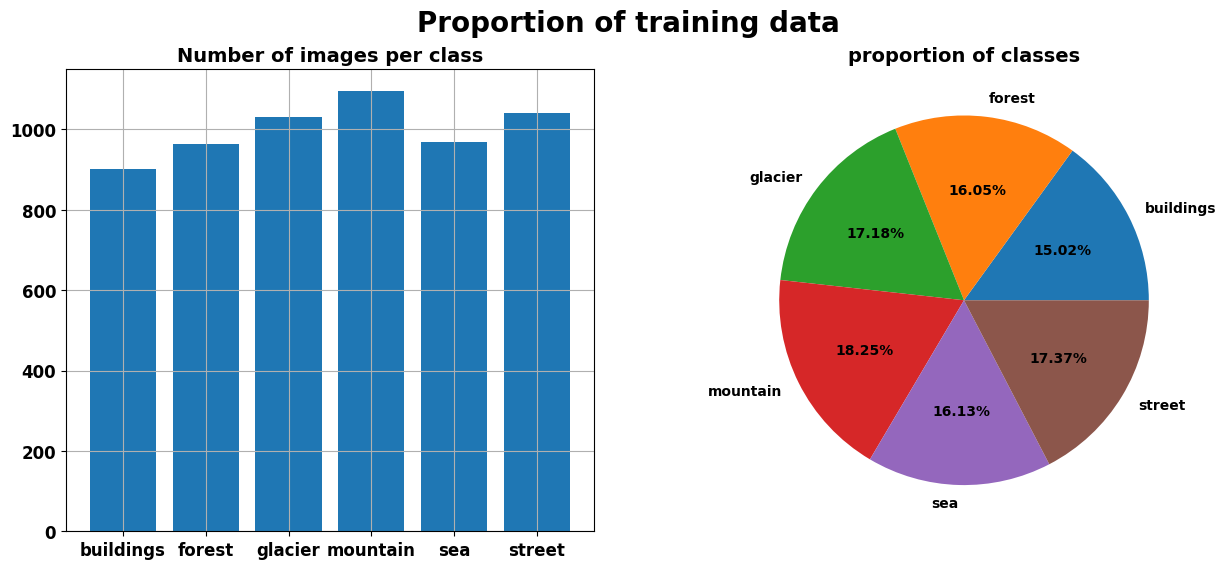

In [54]:
final_s = proportion_labels(train_labels, "training")

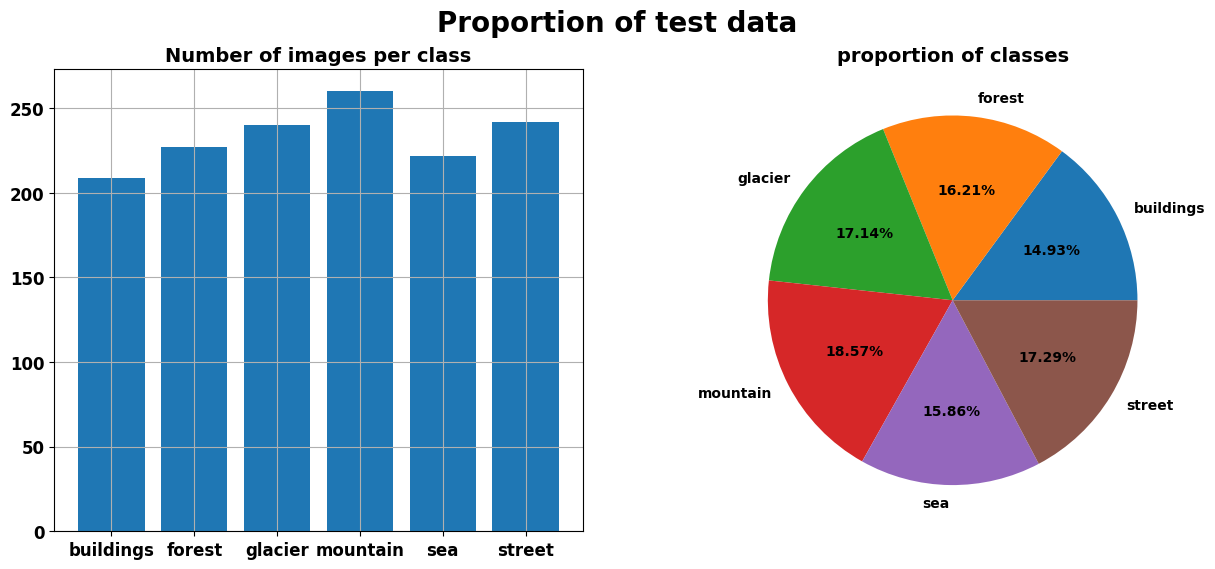

In [55]:
test_d = proportion_labels(test_labels, "test")

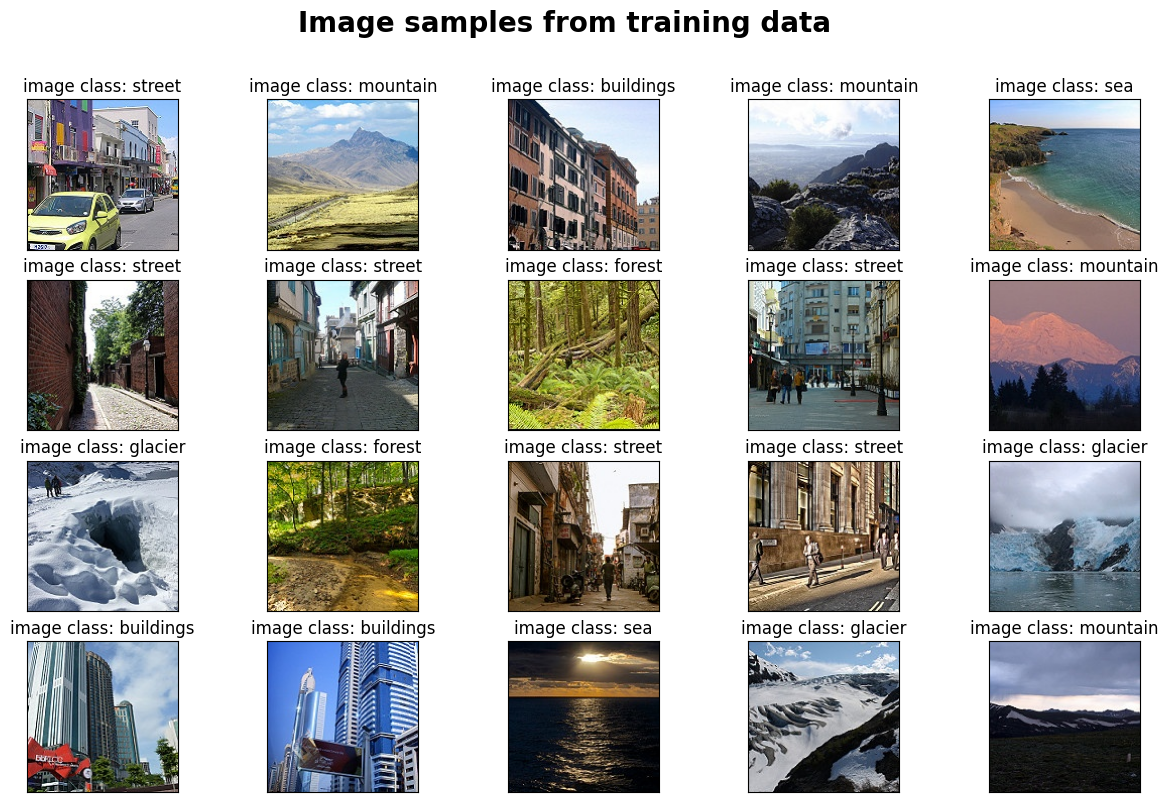

In [56]:
## plot 3*5 visualization of images
plt.figure(figsize=(15,9))
for idx, label in enumerate(train_labels[:20]):
    plt.subplot(4,5, idx+1)
    plt.imshow(trn_images_norm[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'image class: {class_names[label]}')   
    
plt.suptitle(f'Image samples from training data', size=20, weight='bold')
plt.show()

In [57]:
# model architecture of first keras model
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
# convert labels to categorical 
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# compile the model with 'adam' optimizer
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(trn_images_norm, train_labels, batch_size=128, epochs=15, validation_data=(tst_images_norm, test_labels),
                   callbacks=callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(tst_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
 4/47 [=>............................] - ETA: 1:53 - loss: 1.7791 - accuracy: 0.1973